使用GPU云，2个GPU

In [1]:
import collections    # 提供python内置数据类型的扩展版本，如哈希，队列等，用于简化复杂数据结构的处理
import math
import os             # 提供与操作系统交互的功能，如文件路径操作、环境变量访问等
import shutil         # shell utilities, 基于os模块，提供更高级的文件操作功能，如复制、移动、压缩文件等
import pandas as pd
import torch 
import torchvision
from torch import nn 
from d2l import torch as d2l
import py7zr

In [ ]:
def extract_7z(file_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"Extracting {file_path} to {output_dir}...")
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(output_dir)
    print(f"Extraction complete. Files in {output_dir}: {len(os.listdir(output_dir))}")

# 解压数据集（在Kaggle环境中路径如下）
extract_7z('../data/cifar-10/train.7z', '../data/cifar-10/')
extract_7z('../data/cifar-10/test.7z', '../data/cifar-10/')

Extracting ../data/cifar-10/train.7z to ../data/cifar-10/...
Extraction complete. Files in ../data/cifar-10/: 5
Extracting ../data/cifar-10/test.7z to ../data/cifar-10/...


获取并组织数据集

下载数据集

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用Kaggle竞赛的完整数据集，设置demo为False
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

整理数据集

In [3]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]  # rstrip移除右侧空白字符
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本:', len(labels))
print('# 类别:', len(set(labels.values())))

# 训练样本: 50000
# 类别: 10


In [4]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """
    将验证集从原始训练集中拆分出来
    
    Parameters
    -----------
        data_dir : 文件路径
        labels : 标签字典, {'图片序号': '类别'}
        valid_ratio : 验证集样本数与原训练集样本数的比例, 为每个类别拆分出max(nr, 1)张图像, n是样本数最少的类别中的图像数量
    """
    # 训练数据集中样本数最少的
    n = collections.Counter(labels.values()).most_common()[-1][1] # counter统计可哈希对象中元素的出现次数
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}

    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]    # 根据文件名获取标签
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1 
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    
    return n_valid_per_label

In [5]:
def reorg_test(data_dir):
    """在预测期间整理测试集, 以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file), 
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [6]:
def reorg_cifar_10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [7]:
batch_size = 32 if demo else 128   # 若使用完整数据集，设置为更大整数
valid_ratio = 0.1
reorg_cifar_10_data(data_dir, valid_ratio)

图像增广

In [8]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像
    # 生成一个面积为原始图像面积0.64~1倍的小正方形
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),  # 转成张量，并归一化到[0,1]
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],   # CIFAR-10
                                     [0.2023, 0.1994, 0.2010])
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],   # CIFAR-10
                                     [0.2023, 0.1994, 0.2010])
])

读取数据集

train_ds: 仅包含训练集数据，用于模型训练<br>
train_valid_ds: 包含训练集+验证集数据，用于最终模型训练<br>
valid_ds: 验证集数据，用于评估模型性能和调整超参数<br>
test_ds: 测试集数据，用于最终模型评估，不参与训练<br>

In [9]:
# ImageFolder,适合处理按类别分文件夹组织的图像数据
# 能够自动将文件夹名称映射为类别标签
# train_ds[0]样本，为一个图像，一个标签
# train_ds.classes[0] = 'airplane'  classes中是序号和标签文字的映射
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), transform=transform_train) 
    for folder in ['train', 'train_valid']]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), transform=transform_test) 
    for folder in ['valid', 'test']]

In [10]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)]

# 验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

定义模型

In [11]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction='none')

定义训练函数

In [12]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)        # 训练算法
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()   # 共多少小批量
    legend = ['train loss', 'train acc']
    if valid_iter is not None:   # 处于调参环节，有验证集
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()  # 开始训练
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i+1) % (num_batches // 5) == 0 or i == num_batches-1:
                # 训练结果
                animator.add(epoch+(i+1)/num_batches, (metric[0]/metric[2], metric[1]/metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch+1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures+f'\n{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

训练和验证模型

train loss 0.148, train acc 0.948, valid acc 0.802
4057.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


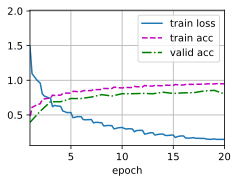

In [13]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.132, train acc 0.954
4272.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


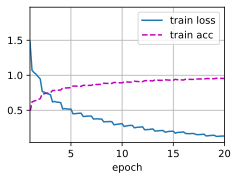

In [14]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

In [15]:
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())  # 获取每个样本预测概率最高的类别
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x:str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)